# Feature extraction with gabor filter and laplacian filter

In [3]:
# import libaries
import numpy as np
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage import morphology
import numpy as np
import glob
import os
import cv2
import os
from PIL import Image
from skimage import feature
from skimage import exposure
import csv

## Generate gabor filter

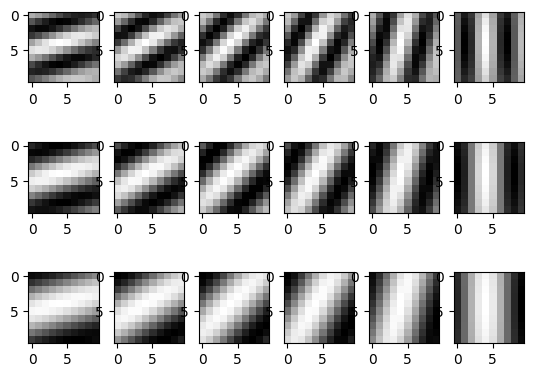

In [4]:
class Gabor():
    def __init__(self, R, C, n_orientation, scale):
        self.R = R
        self.C = C
        self.n_orientation = n_orientation
        self.scale = scale
        self.orientation = np.array([ u * np.pi / n_orientation for u in range (1, n_orientation + 1)])
        self.gabor_filters_sets = [gabor_wavelet(R, C, u, scale, n_orientation) for u in range(1, n_orientation + 1)]

    # filter image through gabor filter
    def filtering(self, img):
        graphs = np.array([cv2.filter2D(img, -1, np.real(gw)) for gw in self.gabor_filters_sets])
        return graphs
    
    def plot_filters(self, n_scale):
        gabor_filters = []
        fig = plt.figure()
        for v in range (1, n_scale + 1):
            for u in range(1, self.n_orientation + 1):
                gw = gabor_wavelet(self.R, self.C, u, v , self.n_orientation)
                fig.add_subplot(n_scale, self.n_orientation, self.n_orientation * (v- 1) + u)
                plt.imshow(np.real(gw), cmap='gray')
        plt.show()

    

def gabor_wavelet(rows, cols, orientation, scale, n_orientation):
    kmax = np.pi / 2        # 1.5707963267948966
    f = np.sqrt(2)          # 1.4142135623730951 
    delt2 = (2 * np.pi) ** 2
    k = (kmax / (f ** scale)) * np.exp(1j * orientation * np.pi / n_orientation / 2)
    kn2 = np.abs(k) ** 2
    gw = np.zeros((rows, cols), np.complex128)

    for m in range(int(-rows / 2) + 1, int(rows / 2) + 1):
        for n in range(int(-cols / 2) + 1, int(cols / 2) + 1):
            t1 = np.exp(-0.5 * kn2 * (m ** 2 + n ** 2) / delt2)
            t2 = np.exp(1j * (np.real(k) * m + np.imag(k) * n))
            t3 = np.exp(-0.5 * delt2)
            gw[int(m + rows / 2 - 1), int(n + cols / 2 - 1)] = (kn2 / delt2) * t1 * (t2 - t3)

    return gw


n_orientation = 6
scale = 2
GA = Gabor(10, 10, n_orientation, scale)
gabor_filters = GA.gabor_filters_sets
GA.plot_filters(3)


## Laplacian Filter

In [5]:
def Lo_pass_Gaussian_procwess(img, D0):
    rows, cols = img.shape
    mask = np.zeros((rows, cols))
    Locx = np.array(list(range(cols)) * rows).reshape([rows, cols])
    Locy = np.transpose((np.array(list(range(rows)) * cols).reshape([cols,rows])))
    D = np.sqrt((Locx - cols / 2) ** 2 + (Locy - rows / 2 ) ** 2)
    mask = np.exp(-D ** 2 / D0 ** 2 / 2)

    f1 = np.fft.fft2(img)
    f1shift = np.fft.fftshift(f1)
    f1shift = f1shift * mask
    f2shift = np.fft.ifftshift(f1shift)
    img_new = np.fft.ifft2(f2shift)
    img_new = np.abs(img_new)

    return img_new

def LOG_preprocess(img, R0 = 40 , ksize = 5):
    AfterGaussian = np.uint8(Lo_pass_Gaussian_procwess(img, R0))
    processed = cv2.Laplacian(AfterGaussian, -1, ksize=ksize)
    img = cv2.equalizeHist(img)             
    return processed

## Process the image to extract feature


In [6]:
def show_array_img(arr, process):
    plt.figure(figsize=(12, 8))  # Đặt kích thước cửa sổ
    for idx, element in enumerate(arr):
        plt.subplot(3, 4, idx + 1)  # Sắp xếp ảnh trên lưới 3x4 (hoặc thay đổi tuỳ số lượng ảnh)
        plt.imshow(element, cmap='gray')  # Hiển thị ảnh ở dạng grayscale
        plt.title(f"{process} {idx+1}")  # Thêm tiêu đề cho từng ảnh
        plt.axis('off')  # Tắt trục toạ độ

    plt.tight_layout()  # Căn chỉnh lưới để không bị chồng lấn
    plt.show()
    
def Gab(img):

    # Laplacian process image with above function
    img = LOG_preprocess(img)

    # storing output after gabor filter
    After_gabor = []

    # Gabor process image with the first cell code above
    for i, gw in enumerate(gabor_filters):
        element =  cv2.filter2D(img, -1, np.real(gw))       # filter2d image với mỗi kernel là một gabor filter 
        After_gabor.append(element)


    # show_array_img(After_gabor, "Gabor")
    
    
    Two_value = []
    for i, line in enumerate(After_gabor):
        _, TW = cv2.threshold(line, 0 , 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        kernel = np.ones((2,2), np.uint8)
        TW = cv2.erode(TW, kernel)

        Two_value.append(TW)

    # show_array_img(Two_value, "threshold")

    con = []


    for i in Two_value:
        conective = morphology.remove_small_objects(i > 0, min_size=40, connectivity=1)
        con.append(conective)

    line = (np.sum(con, axis = 0) / len(con))

    # show_array_img(con, "Remove small object")


    return line 




# HOG

In [7]:
# HOG
    
# HOG với 9 hướng, cell có kích thước 10*10 
def Hog(edge_img):
    (H, hog_img) = feature.hog(edge_img, orientations=9, pixels_per_cell=(10, 10),
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)


    hogImage = exposure.rescale_intensity(hog_img, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")

   

    
    return H,hog_img

# RUN

## Data Folder Path

In [8]:
path = 'roi_test'


In [15]:
def process(path, visualize):
    img = Image.open(path)
    img = img.resize((200, 200))
    
    # nếu là tay trái thì lật ảnh
    if 'l' in path:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        
    # đưa hình ảnh về dạng np.array để có thể sử dụng thư viện cv2
    img = np.array(img)
    
    ori_img = img                               # store image for visualize
    # add the image to the figure
    
    # apply gaussian smotthing
    log_img = LOG_preprocess(img)               # store image for visualize
    
    # apply gabor filter 
    edge_img = Gab(img)

    (H, hog_img) = Hog(edge_img)

    if (visualize):
        plt.figure(figsize=(16,4))
        plt.subplot(141)
        plt.imshow(ori_img,cmap='gray')
        plt.title(path)
        plt.axis('off')

        plt.subplot(142)
        plt.imshow(log_img, cmap='gray')
        plt.title("LOG")
        plt.axis('off')
        
        plt.subplot(143)
        plt.imshow(edge_img, cmap='gray')
        plt.axis('off')
        plt.title('Gabor')

        plt.subplot(144)
        plt.imshow(hog_img)
        plt.title("HOG")
        plt.axis('off')

    
    return H
    




In [ ]:
data = []

cnt = 0
for folder in os.listdir(path):
    cnt += 1
    for file_name in os.listdir(path + '/' + folder):
        file_path = os.path.join(path,folder,file_name)
        item_data = []
        # extract label from file path
        label = file_name.split('_')

        item_data.append(label[0])      # people ex: 0001
        item_data.append(label[1])      # gener ex: m
        item_data.append(label[2])      # hand (left or right) ex: l

        H = process(file_path, True)
        print(H.shape)
        item_data.append(H)

        data.append(item_data)

    
    break




In [10]:

file_name = "data.csv"

# Ghi dữ liệu vào file CSV
with open(file_name, mode="w", encoding="utf-8", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(data)

In [11]:
import pickle
def _save(path, obj):
    with open(path, 'wb') as fn:
        pickle.dump(obj, fn)


_save('data.pkl',data)
